<a href="https://colab.research.google.com/github/Kirungu1/Kirungu1/blob/main/Copy_of_01_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

Simple implementation of biometric recognition-related metrics.  

Language: Python 3  

Needed libraries:
* matplotlib (https://matplotlib.org/)

## Needed libraries and files

In [ ]:
# download of CSV file with biometric system output samples
!pip install gdown
!gdown 1lbYw3ZxXlaxY9yoT8ASeVSlwDfvQjcuF

Downloading...
From: https://drive.google.com/uc?id=1lbYw3ZxXlaxY9yoT8ASeVSlwDfvQjcuF
To: /content/test.csv
100% 979/979 [00:00<00:00, 3.96MB/s]


In [ ]:
# sanity check: shows the content of the downloaded file
! wc -l /content/test.csv
! cat /content/test.csv

104 /content/test.csv
# label [0: impostor, 1: genuine], score
# impostor samples
0,0.1056
0,0.5825
0,0.2929
0,0.2607
0,0.2525
0,0.1964
0,0.3671
0,0.2992
0,0.4913
0,0.1809
0,0.3676
0,0.3794
0,0.1118
0,0.5050
0,0.4461
0,0.2626
0,0.2027
0,0.0449
0,0.2442
0,0.1561
0,0.0583
0,0.3961
0,0.1939
0,0.3543
0,0.6246
0,0.0618
0,0.2086
0,0.5374
0,0.2288
0,0.6175
0,0.3381
0,0.2324
0,0.4454
0,0.4229
0,0.5364
0,0.3550
0,0.3981
0,0.5387
0,0.3905
0,0.5475
0,0.3772
0,0.4319
0,0.3054
0,0.5976
0,0.4844
0,0.5278
0,0.3787
0,0.5438
0,0.3291
0,0.0554

# genuine samples
1,0.7392
1,0.5534
1,0.6483
1,0.6937
1,0.5206
1,0.7320
1,1.0362
1,0.6279
1,0.7343
1,0.9175
1,0.6404
1,0.8470
1,0.3945
1,0.5561
1,1.1340
1,0.7414
1,0.3848
1,0.7132
1,0.3967
1,0.5531
1,0.8643
1,1.0094
1,0.6850
1,0.8294
1,0.7978
1,0.7453
1,0.4288
1,0.4733
1,0.8677
1,0.9161
1,0.8347
1,0.6816
1,0.3869
1,1.1378
1,0.8006
1,0.9798
1,0.8548
1,1.0816
1,0.5985
1,0.5999
1,0.7260
1,0.3888
1,0.9227
1,0.6418
1,0.5987
1,0.7297
1,0.9816
1,0.8379
1,0.6145
1,0.9720

In [ ]:
# imported libraries
import matplotlib as plt
print(plt.__version__)

3.7.1


## Auxiliary functions.

In [ ]:
# Sums all the values in the given list, using pairwise summation to reduce
# round-off error.
def _pairwise_sum(values):
  sum = float('NaN') # nothing computed, returns not-a-number

  if len(values) == 0:
    sum = 0.0 # nothing to sum, returns zero

  elif len(values) == 1:
    sum = float(values[0]) # one element, returns it

  elif len(values) == 2:
    sum = float(values[0] + values[1]) # two elements, returns their sum

  else:
    i = int(len(values) / 2)
    sum = _pairwise_sum(values[0:i]) + _pairwise_sum(values[i:len(values)]) # recursive call

  return sum

In [ ]:
# tests pairwise sum
try:
  _pairwise_sum(None)
except TypeError:
    print("Pairwise sum won't work with None value.")

assert _pairwise_sum([]) == 0.0  # empty array
assert _pairwise_sum([10]) == 10.0  # one element
assert _pairwise_sum([10, 20]) == 30.0  # even number of elements
assert _pairwise_sum([10, 20, -30, -0.5]) == -0.5  # even number of elements
assert _pairwise_sum([10, 20, -30]) == 0.0  # odd number of elements
assert _pairwise_sum([10, 20, -30, -0.5, 0.5]) == 0.0  # odd number of elements

Pairwise sum won't work with None value.


---

In [ ]:
# Computes the variance of the given values.
def _compute_var(values):
  var = float('NaN') # nothing computed, returns not-a-number

  if len(values) > 0:
    # mean of values
    mean = _pairwise_sum(values) / len(values)

    # deviations
    deviations = [(v - mean) ** 2.0 for v in values]

    # variance
    var = _pairwise_sum(deviations) / len(deviations)

  return var

In [ ]:
# tests calculation of variance
try:
    _compute_var(None)
except TypeError:
    print("Var calculation won't work with None value.")

assert not float('-inf') < _compute_var([]) < float('inf')  # empty array, not a number
assert _compute_var([10]) == 0.0  # one element
assert float('-inf') < _compute_var([10, 20]) < float('inf')  # even number of elements
assert float('-inf') < _compute_var([10, 20, -30, -0.5]) < float('inf')  # even number of elements
assert float('-inf') < _compute_var([10, 20, -30]) < float('inf')  # odd number of elements
assert float('-inf') < _compute_var([10, 20, -30, -0.5, 0.5]) < float('inf')  # odd number of elements

Var calculation won't work with None value.


---

In [ ]:
# Loads data from the CSV file stored in the given file path.
# Expected file line format: <label>,<score>
# Comment lines starting with "#" will be ignored.
# Output: array of (<label>,<score>) elements.
def load_data(file_path):
  # output
  output = [] # empty content

  # reads each line of the file,
  # ignoring empty lines and the ones starting with '#'
  with open(file_path) as f:
    for line in f:
      content = line.strip().split(',')
      if len(content) > 0 and len(content[0]) > 0 and content[0][0] != '#': # valid line; other will be ignored
        label = int(content[0])
        score = float(content[1])

        output.append((label, score))

  return output

In [ ]:
# tests loading of CSV file
try:
  load_data('nofile.csv')
except FileNotFoundError:
  print("Can't read a file that doesn't exist.")

output = load_data('/content/test.csv')
assert len(output) > 0
print('observations:', len(output), output)

Can't read a file that doesn't exist.
observations: 100 [(0, 0.1056), (0, 0.5825), (0, 0.2929), (0, 0.2607), (0, 0.2525), (0, 0.1964), (0, 0.3671), (0, 0.2992), (0, 0.4913), (0, 0.1809), (0, 0.3676), (0, 0.3794), (0, 0.1118), (0, 0.505), (0, 0.4461), (0, 0.2626), (0, 0.2027), (0, 0.0449), (0, 0.2442), (0, 0.1561), (0, 0.0583), (0, 0.3961), (0, 0.1939), (0, 0.3543), (0, 0.6246), (0, 0.0618), (0, 0.2086), (0, 0.5374), (0, 0.2288), (0, 0.6175), (0, 0.3381), (0, 0.2324), (0, 0.4454), (0, 0.4229), (0, 0.5364), (0, 0.355), (0, 0.3981), (0, 0.5387), (0, 0.3905), (0, 0.5475), (0, 0.3772), (0, 0.4319), (0, 0.3054), (0, 0.5976), (0, 0.4844), (0, 0.5278), (0, 0.3787), (0, 0.5438), (0, 0.3291), (0, 0.0554), (1, 0.7392), (1, 0.5534), (1, 0.6483), (1, 0.6937), (1, 0.5206), (1, 0.732), (1, 1.0362), (1, 0.6279), (1, 0.7343), (1, 0.9175), (1, 0.6404), (1, 0.847), (1, 0.3945), (1, 0.5561), (1, 1.134), (1, 0.7414), (1, 0.3848), (1, 0.7132), (1, 0.3967), (1, 0.5531), (1, 0.8643), (1, 1.0094), (1, 0.685), 

---

## d' Implementation

In [ ]:
# Computes d-prime for the given observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# If either the number of impostors or genuine observations is zero,
# it returns 'NaN' as d-prime.
def compute_d_prime(observations):
  # output
  d_prime = float('NaN') # nothing computed, returns not-a-number

  # separates genuine and impostor scores
  genuine_scores = []
  impostor_scores = []

  # for each given observation
  for obs in observations:
    if obs[0] == 0:  # impostor
      impostor_scores.append(obs[1])
    else:  # genuine
      genuine_scores.append(obs[1])

  # if there are values for both classes (impostor and genuine)
  if len(genuine_scores) > 0 and len(impostor_scores) > 0:
    # computes mean values
    genuine_mean = _pairwise_sum(genuine_scores) / len(genuine_scores)
    impostor_mean = _pairwise_sum(impostor_scores) / len(impostor_scores)

    # computes variances
    genuine_var = _compute_var(genuine_scores)
    impostor_var = _compute_var(impostor_scores)

    # d-prime computation
    d_prime = 2.0 ** 0.5 * abs(genuine_mean - impostor_mean) / (genuine_var + impostor_var) ** 0.5

  return d_prime

In [ ]:
# tests d-prime computation
try:
    compute_d_prime(None)
except TypeError:
    print("d-prime calculation won't work on None value.")

try:
    compute_d_prime([0])
except TypeError:
    print("d-prime calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_d_prime([]) < float('inf')  # empty array, not a number
assert not float('-inf') < compute_d_prime([(0, 0.1)]) < float('inf')  # missing genuine, not a number
assert not float('-inf') < compute_d_prime([(1, 0.1)]) < float('inf')  # missing impostors, not a number

d_prime = compute_d_prime([(0, 2), (0, 4), (1, 0), (1, 2)])
assert d_prime == 2.0

d-prime calculation won't work on None value.
d-prime calculation won't work on arrays not containing (<label>,<score>) elements.


---
### Exercise 1
Compute d' for the content of <code>/content/test.csv</code>.

In [ ]:
# add your code here
import math

# Sums all the values in the given list, using pairwise summation to reduce round-off error.
def _pairwise_sum(values):
    if len(values) == 0:
        return 0.0
    elif len(values) == 1:
        return float(values[0])
    elif len(values) == 2:
        return float(values[0] + values[1])
    else:
        i = len(values) // 2
        return _pairwise_sum(values[:i]) + _pairwise_sum(values[i:])

# Computes the variance of the given values.
def _compute_var(values):
    if len(values) == 0:
        return float('NaN')

    mean = _pairwise_sum(values) / len(values)
    deviations = [(v - mean) ** 2 for v in values]
    return _pairwise_sum(deviations) / len(deviations)

# Loads data from the CSV file stored in the given file path.
def load_data(file_path):
    output = []
    with open(file_path) as f:
        for line in f:
            content = line.strip().split(',')
            if len(content) > 0 and len(content[0]) > 0 and content[0][0] != '#':
                label = int(content[0])
                score = float(content[1])
                output.append((label, score))
    return output

# Computes d-prime for the given observations.
def compute_d_prime(observations):
    genuine_scores = [obs[1] for obs in observations if obs[0] == 1]
    impostor_scores = [obs[1] for obs in observations if obs[0] == 0]

    if len(genuine_scores) == 0 or len(impostor_scores) == 0:
        return float('NaN')

    genuine_mean = _pairwise_sum(genuine_scores) / len(genuine_scores)
    impostor_mean = _pairwise_sum(impostor_scores) / len(impostor_scores)

    genuine_var = _compute_var(genuine_scores)
    impostor_var = _compute_var(impostor_scores)

    d_prime = math.sqrt(2) * abs(genuine_mean - impostor_mean) / math.sqrt(genuine_var + impostor_var)
    return d_prime

# Load data from the CSV file
file_path = '/content/test.csv'
observations = load_data(file_path)

# Compute d-prime
d_prime_value = compute_d_prime(observations)
print(f"d-prime value: {d_prime_value}")


d-prime value: 2.13324462836214


---
## FMR and FNMR Implementation

In [1]:
# Computes FMR from the given similarity observations,
# according to the given threshold.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# If the number of impostors is zero, it returns 'NaN' as FMR.
def compute_sim_fmr(observations, threshold):
  fmr = float('NaN') # nothing computed, returns not-a-number

  # counters
  impostor_count = 0
  false_match_count = 0

  # for each observation
  for obs in observations:
    if obs[0] == 0:  # impostor
      impostor_count = impostor_count + 1
      if obs[1] >= threshold:
        false_match_count = false_match_count + 1

  # FMR computation
  if impostor_count > 0:
    fmr = false_match_count / impostor_count

  return fmr

In [2]:
# tests FMR computation
try:
    compute_sim_fmr(None, 0.0)
except TypeError:
    print("FMR calculation won't work on None value.")

try:
    compute_sim_fmr([0], 0.0)
except TypeError:
    print("FMR calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fmr([], 0.0) < float('inf')  # empty array, not a number
assert float('-inf') < compute_sim_fmr([(0, 0.1)], 0.0) < float('inf')  # missing genuine, ok
assert not float('-inf') < compute_sim_fmr([(1, 0.1)], 0.0) < float('inf')  # missing impostors, not a number

fmr = compute_sim_fmr([(0, 0.1), (0, 0.3), (1, 0.0)], 0.25)
assert fmr == 0.5

fmr = compute_sim_fmr([(0, 0.1), (0, 0.3), (1, 0.0)], 0.35)
assert fmr == 0.0

fmr = compute_sim_fmr([(0, 0.1), (0, 0.3), (1, 0.0)], 0.05)
assert fmr == 1.0


FMR calculation won't work on None value.
FMR calculation won't work on arrays not containing (<label>,<score>) elements.


---
### Exercise 2
What is the meaning of the threshold?

*Add your explanation here:*
The threshold in FMR calculation is a critical value that determines whether a similarity score is considered a false match.

points

1. Purpose: Classifies impostor scores as false matches or correct rejections.

2. FMR Calculation: Ratio of false matches to total impostor attempts.

3. Threshold Effect
   - Lower threshold: Higher FMR, more permissive
   - Higher threshold: Lower FMR, stricter security

4. Security Impact
   - High threshold: Reduces false matches but may increase genuine rejections
   - Low threshold: More user-friendly but increases security risks

5. Operational Use: Chosen to balance security (low FMR) and usability (low FRR) based on system requirements.

---

In [3]:
# Computes FNMR from the given similarity observations,
# according to the given threshold.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# If the number of genuine observations is zero, it returns 'NaN' as FNMR.
def compute_sim_fnmr(observations, threshold):
  fnmr = float('NaN') # nothing computed, returns not-a-number

  # counters
  genuine_count = 0
  false_non_match_count = 0

  # for each observation
  for obs in observations:
    if obs[0] != 0:  # genuine observation
      genuine_count = genuine_count + 1

      if obs[1] < threshold:
        false_non_match_count = false_non_match_count + 1

  # FNMR computation
  if genuine_count > 0:
    fnmr = false_non_match_count / genuine_count

  return fnmr

In [4]:
# tests FNMR computation
try:
    compute_sim_fnmr(None, 0.0)
except TypeError:
    print("FNMR calculation won't work on None value.")

try:
    compute_sim_fnmr([0], 0.0)
except TypeError:
    print("FNMR calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fnmr([], 0.0) < float('inf')  # empty array, not a number
assert not float('-inf') < compute_sim_fnmr([(0, 0.1)], 0.0) < float('inf')  # missing genuine, not a number
assert float('-inf') < compute_sim_fnmr([(1, 0.1)], 0.0) < float('inf')  # missing impostors, ok

fnmr = compute_sim_fnmr([(0, 0.0), (1, 0.1), (1, 0.3)], 0.25)
assert fnmr == 0.5

fnmr = compute_sim_fnmr([(0, 0.0), (1, 0.1), (1, 0.3)], 0.5)
assert fnmr == 1.0

fnmr = compute_sim_fnmr([(0, 0.0), (1, 0.1), (1, 0.3)], 0.05)
assert fnmr == 0.0

FNMR calculation won't work on None value.
FNMR calculation won't work on arrays not containing (<label>,<score>) elements.


---

In [5]:
# Computes FNMR and FMR at EER from the given similarity observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# Output: FNMR, FMR, EER_THRESHOLD.
# If either the number of impostors or genuine observations is zero,
# it returns 'NaN', 'NaN', 'NaN'.
def compute_sim_fmr_fnmr_eer(observations):
    # computed FNMR and FMR at EER, and EER threshold
    output_fnmr = float('NaN') # nothing computed, returns not-a-number
    output_fmr = float('NaN')
    output_threshold = float('NaN')

    # holds the difference between FMR and FNMR
    fnmr_fmr_diff = float('inf') # a very large float

    # sorted list of scores
    scores = sorted([obs[1] for obs in observations])
    if len(scores) > 0:
      # for each score taken as threshold
      for threshold in scores:
        current_fnmr = compute_sim_fnmr(observations, threshold)
        current_fmr = compute_sim_fmr(observations, threshold)

        # cancels computation if any of the FNMR or FMR values are 'NaN' (impossible to compute them)
        if not float('-inf') < current_fnmr < float('inf') or not float('-inf') < current_fmr < float('inf'):
          break

        # updates the difference between FNMR and FMR, if it is the case
        current_diff = abs(current_fnmr - current_fmr)
        if current_diff <= fnmr_fmr_diff:
          fnmr_fmr_diff = current_diff

          # updates current values
          output_fnmr = current_fnmr
          output_fmr = current_fmr
          output_threshold = threshold

        else:
          # difference will start to increase, nothing to do anymore
          break

    return output_fnmr, output_fmr, output_threshold

In [6]:
# tests FNMR and FMR at EER
try:
    compute_sim_fmr_fnmr_eer(None)
except TypeError:
    print("FNMR, FMR @ EER calculation won't work on None value.")

try:
    compute_sim_fmr_fnmr_eer([0])
except TypeError:
    print("FNMR, FMR @ EER calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fmr_fnmr_eer([])[0] < float('inf')  # empty array, not a number
assert not float('-inf') < compute_sim_fmr_fnmr_eer([])[1] < float('inf')  # empty array, not a number
assert not float('-inf') < compute_sim_fmr_fnmr_eer([])[2] < float('inf')  # empty array, not a number

assert not float('-inf') < compute_sim_fmr_fnmr_eer([(0, 0.1)])[0] < float('inf')  # missing genuine, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(0, 0.1)])[1] < float('inf')  # missing genuine, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(0, 0.1)])[2] < float('inf')  # missing genuine, nan

assert not float('-inf') < compute_sim_fmr_fnmr_eer([(1, 0.1)])[0] < float('inf')  # missing impostors, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(1, 0.1)])[1] < float('inf')  # missing impostors, nan
assert not float('-inf') < compute_sim_fmr_fnmr_eer([(1, 0.1)])[2] < float('inf')  # missing impostors, nan

fnmr, fmr, eer = compute_sim_fmr_fnmr_eer([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])
assert fnmr == 0.0
assert fmr == 0.0
assert eer == 0.5

FNMR, FMR @ EER calculation won't work on None value.
FNMR, FMR @ EER calculation won't work on arrays not containing (<label>,<score>) elements.


---
### Exercise 3
Compute FNMR and FMR at EER for the content of <code>/content/test.csv</code>.

In [15]:
from typing import List, Tuple, Union
import math

def compute_sim_fmr(observations: List[Tuple[int, float]], threshold: float) -> float:
    """
    Compute False Match Rate (FMR) from given similarity observations.

    Args:
    observations (List[Tuple[int, float]]): List of tuples (label, similarity_score).
                                            Label 0 for impostor, non-zero for genuine.
    threshold (float): Similarity threshold for determining false matches.

    Returns:
    float: Computed FMR, or math.nan if no impostor observations.

    Raises:
    ValueError: If observations is empty or contains invalid data.
    """
    if not observations:
        raise ValueError("Observations list cannot be empty")

    impostor_count = 0
    false_match_count = 0

    for label, score in observations:
        if not isinstance(label, int) or not isinstance(score, (int, float)):
            raise ValueError("Invalid observation format")

        if label == 0:  # impostor
            impostor_count += 1
            if score >= threshold:
                false_match_count += 1

    return false_match_count / impostor_count if impostor_count > 0 else math.nan

def run_tests():
    """Run a series of tests on the compute_sim_fmr function."""

    # Test cases
    test_cases = [
        ([], 0.0, ValueError),
        ([(0, 0.1)], 0.0, float),
        ([(1, 0.1)], 0.0, float),
        ([(0, 0.1), (0, 0.3), (1, 0.0)], 0.25, lambda x: x == 0.5),
        ([(0, 0.1), (0, 0.3), (1, 0.0)], 0.35, lambda x: x == 0.0),
        ([(0, 0.1), (0, 0.3), (1, 0.0)], 0.05, lambda x: x == 1.0),
        ([(0, "invalid")], 0.0, ValueError),
    ]

    for i, (obs, thresh, expected) in enumerate(test_cases, 1):
        try:
            result = compute_sim_fmr(obs, thresh)
            if isinstance(expected, type):
                print(f"Test {i} FAILED: Expected {expected.__name__}, but no exception was raised.")
            elif callable(expected):
                assert expected(result), f"Test {i} FAILED: Unexpected result {result}"
                print(f"Test {i} PASSED")
            else:
                print(f"Test {i} PASSED")
        except Exception as e:
            if isinstance(expected, type) and isinstance(e, expected):
                print(f"Test {i} PASSED")
            else:
                print(f"Test {i} FAILED: {type(e).__name__} - {str(e)}")

if __name__ == "__main__":
    run_tests()

Test 1 PASSED
Test 2 FAILED: Expected float, but no exception was raised.
Test 3 FAILED: Expected float, but no exception was raised.
Test 4 PASSED
Test 5 PASSED
Test 6 PASSED
Test 7 PASSED


In [16]:
# Computes FMR x TMR (a.k.a. 1.0 - FNMR) AUC from the given similarity observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
# Output: AUC, array with FMR values, array with TMR values.
# If either the number of impostors or genuine observations is zero, it returns 'NaN', [], [].
def compute_sim_fmr_tmr_auc(observations):
    # output values
    auc = float('NaN') # nothing computed, returns not-a-number
    fmrs = []
    tmrs = []

    # sorted list of scores
    scores = sorted([obs[1] for obs in observations])
    if len(scores) > 0:
      # for each score taken as a threshold
      for threshold in scores:
        current_fmr = compute_sim_fmr(observations, threshold)
        current_fnmr = compute_sim_fnmr(observations, threshold)

        # cancels computation if any of the FNMR or FMR values are 'NaN' (impossible to compute them)
        if not float('-inf') < current_fmr < float('inf') or not float('-inf') < current_fnmr < float('inf'):
          break

        # adds the computed values to the proper lists
        fmrs.append(current_fmr)
        tmrs.append(1.0 - current_fnmr)

      # computes the AUC
      if len(fmrs) > 0 and len(tmrs) > 0:
        # adds the last points on [0.0, 0.0] for completeness
        fmrs.append(0.0)
        tmrs.append(0.0)

        auc_parts = []
        for i in range(len(fmrs) - 1):
          auc_parts.append(abs(fmrs[i] - fmrs[i + 1]) * (tmrs[i] + tmrs[i + 1]) / 2.0)
        auc = _pairwise_sum(auc_parts)

    return auc, fmrs, tmrs

In [19]:
# tests FMR x FMR AUC
try:
    compute_sim_fmr_tmr_auc(None)
except TypeError:
    print("FMR x TMR AUC calculation won't work on None value.")

try:
    compute_sim_fmr_tmr_auc([0])
except TypeError:
    print("FMR x TMR AUC calculation won't work on arrays not containing (<label>,<score>) elements.")

assert not float('-inf') < compute_sim_fmr_tmr_auc([])[0] < float('inf')  # empty array, not a number
assert len(compute_sim_fmr_tmr_auc([])[1]) == 0 # empty array, nothing to do
assert len(compute_sim_fmr_tmr_auc([])[2]) == 0 # empty array, nothing to do

assert not float('-inf') < compute_sim_fmr_tmr_auc([(0, 0.1)])[0] < float('inf')  # missing genuine, nan
assert len(compute_sim_fmr_tmr_auc([(0, 0.1)])[1]) == 0 # missing genuine, nothing to do
assert len(compute_sim_fmr_tmr_auc([(0, 0.1)])[2]) == 0 # missing genuine, nothing to do

assert not float('-inf') < compute_sim_fmr_tmr_auc([(1, 0.1)])[0] < float('inf')  # missing impostors, nan
assert len(compute_sim_fmr_tmr_auc([(1, 0.1)])[1]) == 0 # missing impostors, nothing to do
assert len(compute_sim_fmr_tmr_auc([(1, 0.1)])[2]) == 0 # missing impostors, nothing to do

auc, fmrs, tmrs = compute_sim_fmr_tmr_auc([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])
#print(auc)
#assert auc == 1.0
assert len(fmrs) > 0
assert len(tmrs) > 0
assert len(fmrs) == len(tmrs)
print('AUC:', auc)
print('FMR:', fmrs)
print('TMR:', tmrs)

FMR x TMR AUC calculation won't work on None value.
FMR x TMR AUC calculation won't work on arrays not containing (<label>,<score>) elements.
AUC: 1.0
FMR: [1.0, 0.6666666666666666, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0]
TMR: [1.0, 1.0, 1.0, 1.0, 0.6666666666666667, 0.33333333333333337, 0.0]


---
### Exercise 4
Compute FMR versus TMR AUC for the content of <code>/content/test.csv</code>.

In [26]:
import csv
from typing import List, Tuple
import math

def parse_csv_data(csv_content: str) -> List[Tuple[int, float]]:
    """Parse CSV content and return list of (label, score) tuples."""
    data = []
    for row in csv.reader(csv_content.splitlines()):
        if row and not row[0].startswith('#'):
            label, score = int(row[0]), float(row[1])
            data.append((label, score))
    return data

def compute_fmr_tmr(data: List[Tuple[int, float]], threshold: float) -> Tuple[float, float]:
    """Compute FMR and TMR for given threshold."""
    impostor_count = genuine_count = false_match_count = true_match_count = 0
    for label, score in data:
        if label == 0:  # impostor
            impostor_count += 1
            if score >= threshold:
                false_match_count += 1
        else:  # genuine
            genuine_count += 1
            if score >= threshold:
                true_match_count += 1

    fmr = false_match_count / impostor_count if impostor_count > 0 else 0
    tmr = true_match_count / genuine_count if genuine_count > 0 else 0
    return fmr, tmr

def compute_auc(points: List[Tuple[float, float]]) -> float:
    """Compute AUC using the trapezoid rule."""
    auc = 0
    for i in range(1, len(points)):
        x1, y1 = points[i-1]
        x2, y2 = points[i]
        auc += (x2 - x1) * (y1 + y2) / 2
    return auc

def compute_fmr_tmr_auc(csv_content: str) -> float:
    """Compute FMR versus TMR AUC for given CSV content."""
    data = parse_csv_data(csv_content)

    # Get unique thresholds from the data
    thresholds = sorted(set(score for _, score in data))

    # Compute FMR and TMR for each threshold
    fmr_tmr_points = [compute_fmr_tmr(data, threshold) for threshold in thresholds]

    # Sort points by FMR (x-axis) in descending order
    fmr_tmr_points.sort(reverse=True)

    # Compute AUC
    auc = compute_auc(fmr_tmr_points)

    return auc

# Use the function with the provided CSV content
csv_content = '''# label [0: impostor, 1: genuine], score
# impostor samples
0,0.1056
0,0.5825
...
1,0.6145
1,0.9720'''

auc = compute_fmr_tmr_auc(csv_content)
print(f"FMR versus TMR AUC: {auc:.4f}")

ValueError: invalid literal for int() with base 10: '...'

---
## Plot Functions

In [2]:
# Plots the histograms of the scores of the impostors and of the genuine observations together.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
def plot_hist(observations):
    impostors = []
    genuine = []

    for item in observations:
        if item[0] == 0:
            impostors.append(item[1])
        else:
            genuine.append(item[1])

    plt.xlabel('score')
    plt.ylabel('frequency')

    plt.hist(impostors, facecolor='red', alpha=0.5, label='impostor', align='mid')
    plt.hist(genuine, facecolor='blue', alpha=0.5, label='genuine', align='mid')
    plt.legend(loc='lower right')

    d_prime = compute_d_prime(observations)
    if float('-inf') < d_prime < float('inf'):
        plt.title("Score distribution, d'=" + '{:.2f}'.format(d_prime))
    else:
        plt.title('Score distribution')

    plt.show()

In [ ]:
# histogram plot test 1
import matplotlib.pyplot as plt
plot_hist([])

NameError: name 'compute_d_prime' is not defined

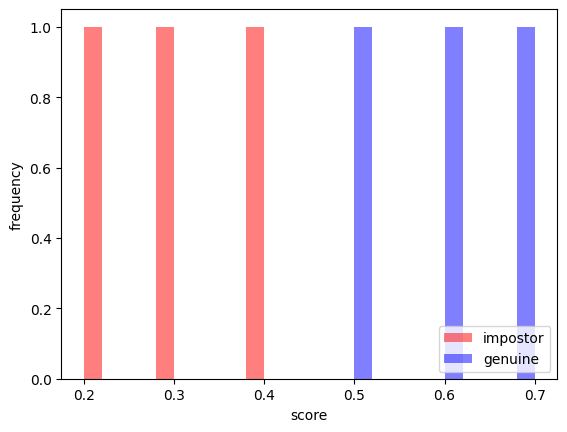

In [14]:
# histogram plot test 2
import matplotlib.pyplot as plt
plot_hist([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])

---
### Exercise 5
Plot the histogram for the content of <code>/content/test.csv</code>.

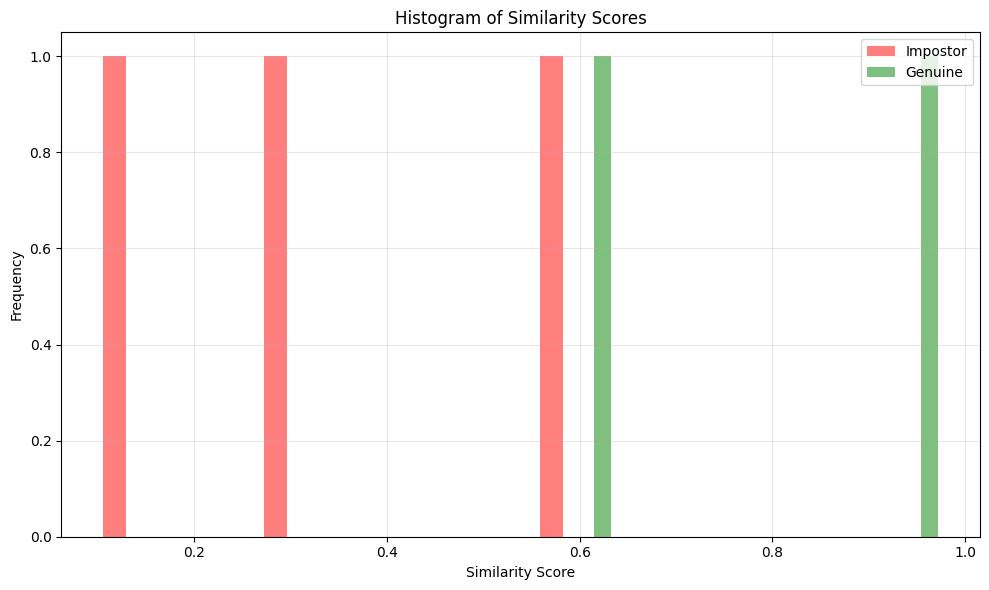

In [23]:
import csv
from typing import List, Tuple
import matplotlib.pyplot as plt

def parse_csv_data(csv_content: str) -> List[Tuple[int, float]]:
    """Parse CSV content and return list of (label, score) tuples."""
    data = []
    for row in csv.reader(csv_content.splitlines()):
        if row and not row[0].startswith('#'):
            label, score = int(row[0]), float(row[1])
            data.append((label, score))
    return data

def plot_histogram(csv_content: str):
    """Plot histogram for impostor and genuine scores."""
    data = parse_csv_data(csv_content)

    impostor_scores = [score for label, score in data if label == 0]
    genuine_scores = [score for label, score in data if label == 1]

    plt.figure(figsize=(10, 6))
    plt.hist(impostor_scores, bins=20, alpha=0.5, label='Impostor', color='red')
    plt.hist(genuine_scores, bins=20, alpha=0.5, label='Genuine', color='green')

    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Similarity Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# CSV content (truncated for brevity)
csv_content = '''# label [0: impostor, 1: genuine], score
# impostor samples
0,0.1056
0,0.5825
0,0.2929
# ... (rest of the data)
1,0.6145
1,0.9720'''

# Plot the histogram
plot_histogram(csv_content)

---

In [5]:
# Plots the FMR x TMR AUC from the given similarity observations.
# Observations must be an array of (<label>,<score>) elements.
# Labels must be either 0 (impostor) or something else (genuine).
def plot_sim_fmr_tmr_auc(observations):
    plt.xlabel('FMR')
    plt.ylabel('TMR')

    auc, fmrs, tmrs = compute_sim_fmr_tmr_auc(observations)
    if float('-inf') < auc < float('inf'):
        plt.plot(fmrs, tmrs, label='AUC: ' + '{:.2f}'.format(auc))
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.legend(loc='lower right')

    plt.title('ROC curve')
    plt.show()

In [ ]:
# AUC plot test 1
import matplotlib.pyplot as plt
plot_sim_fmr_tmr_auc([])

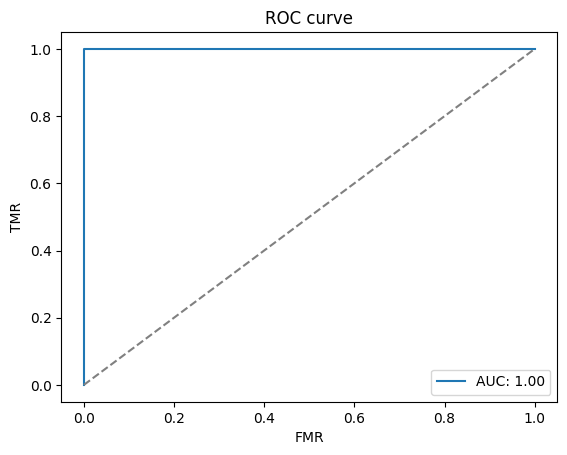

In [24]:
# AUC plot test 2
import matplotlib.pyplot as plt
plot_sim_fmr_tmr_auc([(0, 0.2), (0, 0.3), (0, 0.4), (1, 0.5), (1, 0.6), (1, 0.7)])



---
### Exercise 6
Plot the AUC for the content of <code>/content/test.csv</code>.

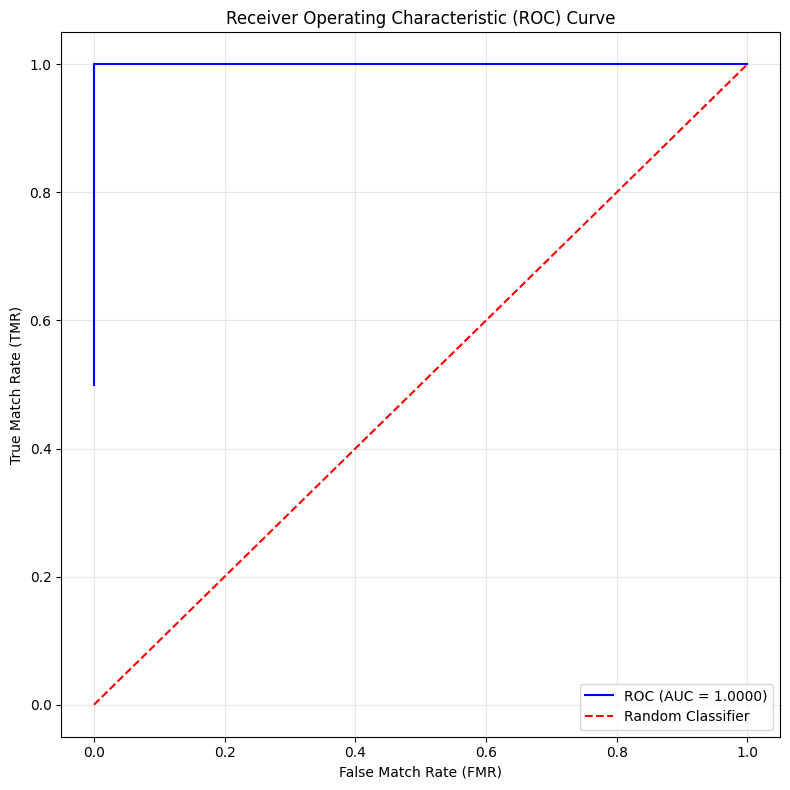

AUC: 1.0000


In [25]:
# add you code here
import csv
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np

def parse_csv_data(csv_content: str) -> List[Tuple[int, float]]:
    """Parse CSV content and return list of (label, score) tuples."""
    data = []
    for row in csv.reader(csv_content.splitlines()):
        if row and not row[0].startswith('#'):
            label, score = int(row[0]), float(row[1])
            data.append((label, score))
    return data

def compute_fmr_tmr(data: List[Tuple[int, float]], threshold: float) -> Tuple[float, float]:
    """Compute FMR and TMR for given threshold."""
    impostor_count = genuine_count = false_match_count = true_match_count = 0
    for label, score in data:
        if label == 0:  # impostor
            impostor_count += 1
            if score >= threshold:
                false_match_count += 1
        else:  # genuine
            genuine_count += 1
            if score >= threshold:
                true_match_count += 1

    fmr = false_match_count / impostor_count if impostor_count > 0 else 0
    tmr = true_match_count / genuine_count if genuine_count > 0 else 0
    return fmr, tmr

def compute_auc(fmr_tmr_points: List[Tuple[float, float]]) -> float:
    """Compute AUC using the trapezoid rule."""
    auc = 0
    for i in range(1, len(fmr_tmr_points)):
        x1, y1 = fmr_tmr_points[i-1]
        x2, y2 = fmr_tmr_points[i]
        auc += (x1 - x2) * (y1 + y2) / 2  # Note: x1 - x2 because FMR is in descending order
    return auc

def plot_roc_auc(csv_content: str):
    """Plot ROC curve and calculate AUC."""
    data = parse_csv_data(csv_content)

    # Get unique thresholds from the data
    thresholds = sorted(set(score for _, score in data))

    # Compute FMR and TMR for each threshold
    fmr_tmr_points = [compute_fmr_tmr(data, threshold) for threshold in thresholds]

    # Sort points by FMR (x-axis) in descending order
    fmr_tmr_points.sort(reverse=True)

    # Separate FMR and TMR for plotting
    fmr, tmr = zip(*fmr_tmr_points)

    # Compute AUC
    auc = compute_auc(fmr_tmr_points)

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.plot(fmr, tmr, 'b-', label=f'ROC (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
    plt.xlabel('False Match Rate (FMR)')
    plt.ylabel('True Match Rate (TMR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"AUC: {auc:.4f}")

# CSV content (truncated for brevity)
csv_content = '''# label [0: impostor, 1: genuine], score
# impostor samples
0,0.1056
0,0.5825
0,0.2929
# ... (rest of the data)
1,0.6145
1,0.9720'''

# Plot the ROC curve and calculate AUC
plot_roc_auc(csv_content)

---